## 剪枝算法尝试

In [7]:
import numpy as np
import sys
import time

import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../data/')
from resnet import resnet
from preact_resnet import PreActResNet18
from load_cifar import load_cifar
from load_olivetti import load_olivetti

In [8]:
# 函数们
def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])

def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    X_train_flip = X_train[:, :, :, ::-1]
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    y_train = np.concatenate((y_train, y_train), axis=0)
    return X_train, y_train, X_test

def image_metrics(img1, img2):
    # return mean abs error and cosine distance
    img1 = img1.astype(float).flatten()
    img2 = img2.astype(float).flatten()
    return np.mean(np.abs(img1 - img2)),  np.abs(np.dot(img1, img2) / (np.linalg.norm(img1) * np.linalg.norm(img2)))

def load_params(name):
    path = MODEL_DIR + name +".npz"
    with np.load(path) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    return param_values

def normalize(x):
    x_shape = x.shape
    x = x.flatten()
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)
    return x.reshape(x_shape)

def iterate_minibatches(inputs, targets, batch_size):
    assert len(inputs) == len(targets)
    start_idx = None
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]

    if start_idx is not None and start_idx + batch_size < len(inputs):
        excerpt = slice(start_idx + batch_size, len(inputs))
        yield inputs[excerpt], targets[excerpt]

#### 加载数据，构造恶意数据

In [9]:
def mal_data_synthesis(train_x, num_targets=10, precision=4):
    # synthesize malicious images to encode secrets
    # for CIFAR, use 2 data points to encode one approximate 4-bit pixel
    # thus divide the number of targets by 2
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:  # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            # get the 4-bit approximation of 8-bit pixel
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            # use 2 data points to encode p
            # e.g. pixel=15, use (x1, 7), (x2, 8) to encode
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                # initialize a empty image
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                # simple & naive deterministic value for two pixel
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets


In [11]:
# param_values = torch.load(MODEL_DIR+'cifar/resnet/cifar_cap_res5_0.1_model.ckpt')
param_values = torch.load('ckpts/olivetti_cap_preact_1_model.ckpt')

X_train, y_train, X_test, y_test = load_olivetti()

# X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
# X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
# X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
# X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)

input_shape = (None, 3, X_train.shape[2], X_train.shape[3])
n_out = len(np.unique(y_train))

network = PreActResNet18(num_classes=40)

network.load_state_dict(param_values)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
mal_n = 1
# recreate malicious feature vector
X_mal, y_mal, mal_n = mal_data_synthesis(X_train, num_targets=mal_n)

X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
n_out = len(np.unique(y_train))

#### 隐藏层抽取

In [13]:
out_list = []
network.to('cuda')
network.eval()
with torch.no_grad():
    for batch in iterate_minibatches(X_mal, y_mal, 1024):
        inputs, _ = batch
        outs = network.inner(torch.from_numpy(inputs).to('cuda')).cpu().data.numpy()
        out_list.extend(list(outs))
np_out_list = np.array(out_list)
print(np_out_list.shape)

(2048, 512)


In [14]:
means = np_out_list.mean(axis=0)

In [15]:
seq_sort_mal = np.argsort(means)

In [16]:
seq_sort_mal

array([182, 341, 376, 243, 338, 191, 109, 187, 297, 442, 477, 436, 407,
       100,  19,  89, 239, 226,  37, 228, 213,  83, 169, 151, 223,  80,
        88, 403, 505, 186, 122, 273, 319, 261, 200, 102, 371,  39, 293,
        96, 316,  51, 388, 431, 374, 327,  55, 486, 360,  45, 365, 208,
       479, 445, 410, 290, 173, 470,   8, 482, 506,  21, 285, 158, 201,
       193,  50, 349,  26, 262,  95, 345, 276, 455, 498, 465, 104,  42,
       137, 408, 260,  64, 467, 307,  20, 211, 265, 440, 206,  32, 379,
       258, 280, 129,   9, 434, 249, 425, 275, 144, 426, 194,  13, 497,
        81, 250, 480,  79, 487, 456, 244, 359, 105, 252, 381, 210,  61,
       178, 414, 101, 235, 220, 364,  11, 361, 270, 503, 183, 451, 420,
       325, 342,  70,   1, 432, 463, 429, 501, 255,  78,  44, 248, 225,
       336, 120, 209, 288, 140, 405, 237, 344, 112, 190,  58,  29, 254,
       496, 166, 383, 471, 350, 257, 495,  49, 289, 268, 412, 147, 421,
       215, 418, 306, 315, 416,  38,  91,   6, 507, 309, 241, 28

In [17]:
np_clean_list = []
with torch.no_grad():
    for batch in iterate_minibatches(X_train, y_train, 40):
        inputs, _ = batch
        outs = network.inner(torch.from_numpy(inputs).to('cuda')).cpu().data.numpy()
        np_clean_list.extend(list(outs))
np_clean_list = np.array(np_clean_list)
print(np_clean_list.shape)

(560, 512)


In [18]:
cl_means = np_clean_list.mean(axis=0)
seq_sort_clean = np.argsort(cl_means)

In [19]:
seq_sort_clean

array([  8, 488, 382, 171, 118, 321, 276, 159, 250, 247, 238,  70, 120,
       124, 258, 305,  34, 462, 109,  41,  29, 388, 327,  68, 283, 465,
       143, 157,  32,  30, 372,  76, 432, 436, 444, 390, 349, 237, 208,
       249, 265,  53, 475, 178, 341,  12, 294, 511, 286, 293, 363, 259,
       155, 467, 396,  86, 420, 295,  50, 374, 448, 503, 236, 463, 147,
       343, 100, 123, 153, 403,  94, 101, 497, 401, 456, 225, 380, 125,
       501,  82,  80, 496, 205, 476,  22, 203,  87, 133, 340, 424, 185,
       333, 454,  23,  16, 484, 434,  83, 313, 174,  25, 106, 241,  36,
        35,  88, 464, 308, 364,  31, 326, 128, 426,  10, 472, 211,  26,
       307, 262, 369, 166, 498, 359, 407,   7, 121, 175, 227, 431, 323,
       199, 482, 278, 235,  17, 243, 206, 161, 366, 226, 200, 509, 156,
       122, 187, 218, 119, 103, 186, 428, 337, 298, 264, 399, 324, 177,
       256, 230, 370,  58, 248, 137, 239, 296,  95, 502, 198, 183, 402,
       108, 437, 270, 267,  93,  79, 129, 164, 141,  45, 433, 19

In [20]:
stat = []
mal = seq_sort_mal[::-1]
clean = seq_sort_clean[::-1]
print(" & ".join([str(x) for i,x in enumerate(mal) if (i+1) % 4 == 0]))
print(" & ".join([str(x) for i,x in enumerate(clean) if (i+1) % 4 == 0]))
for i in range(512):
    a = list(clean[:(i+1)])
    b = list(mal[:(i+1)])
    a.reverse()
    b.reverse()
    ab = a
    ab.extend(b)
    rest = 2*(i+1)-len(set(ab))
    stat.append(rest)


454 & 75 & 192 & 197 & 54 & 57 & 146 & 130 & 199 & 251 & 366 & 433 & 326 & 17 & 340 & 136 & 328 & 108 & 267 & 400 & 93 & 389 & 419 & 207 & 466 & 162 & 16 & 460 & 382 & 34 & 43 & 500 & 384 & 510 & 308 & 27 & 236 & 511 & 417 & 367 & 489 & 415 & 310 & 119 & 300 & 76 & 154 & 318 & 63 & 377 & 159 & 424 & 435 & 448 & 298 & 113 & 5 & 48 & 458 & 219 & 149 & 229 & 218 & 279 & 142 & 370 & 259 & 348 & 25 & 395 & 221 & 202 & 385 & 0 & 346 & 121 & 314 & 157 & 390 & 329 & 15 & 441 & 284 & 6 & 315 & 421 & 289 & 350 & 496 & 190 & 405 & 120 & 44 & 429 & 70 & 451 & 361 & 235 & 61 & 105 & 487 & 81 & 426 & 249 & 280 & 206 & 20 & 260 & 104 & 276 & 26 & 201 & 506 & 173 & 479 & 360 & 374 & 316 & 371 & 319 & 505 & 223 & 213 & 239 & 407 & 297 & 338 & 182
309 & 47 & 393 & 331 & 73 & 387 & 99 & 62 & 440 & 446 & 39 & 325 & 457 & 5 & 505 & 302 & 478 & 107 & 499 & 193 & 149 & 15 & 245 & 102 & 405 & 44 & 197 & 242 & 367 & 395 & 481 & 162 & 165 & 423 & 362 & 412 & 257 & 132 & 37 & 376 & 184 & 414 & 392 & 449 & 65 & 4

In [21]:
len(stat)

512

In [22]:
print(" & ".join([str(x) for i,x in enumerate(stat) if (i+1) % 4 == 0]))

0 & 0 & 0 & 0 & 1 & 1 & 2 & 3 & 3 & 3 & 4 & 4 & 5 & 6 & 7 & 7 & 8 & 10 & 11 & 12 & 14 & 16 & 19 & 20 & 21 & 23 & 26 & 28 & 29 & 33 & 35 & 37 & 38 & 39 & 43 & 46 & 48 & 49 & 52 & 56 & 59 & 61 & 65 & 68 & 70 & 72 & 73 & 80 & 80 & 84 & 85 & 88 & 92 & 97 & 99 & 103 & 107 & 110 & 111 & 115 & 120 & 121 & 125 & 132 & 137 & 140 & 143 & 149 & 152 & 156 & 161 & 168 & 175 & 182 & 186 & 188 & 194 & 196 & 202 & 207 & 215 & 220 & 224 & 230 & 236 & 243 & 248 & 253 & 258 & 265 & 271 & 277 & 282 & 287 & 290 & 295 & 302 & 306 & 309 & 315 & 322 & 328 & 335 & 340 & 348 & 354 & 361 & 367 & 375 & 381 & 388 & 393 & 401 & 407 & 415 & 421 & 427 & 434 & 442 & 449 & 457 & 465 & 473 & 480 & 488 & 496 & 504 & 512


In [23]:
mal[:3]

array([278,  28, 133])

In [24]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname="./simhei.ttf")
import pylab as p

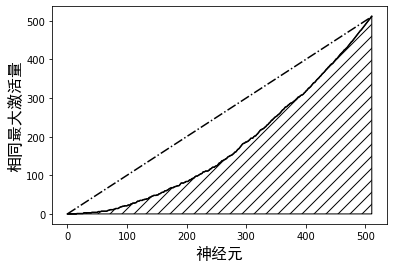

In [25]:
plt.plot([x for x in range(len(stat))],stat, 'k')
plt.plot([x for x in range(len(stat))],[x for x in range(len(stat))], 'k-.')
plt.fill_between([x for x in range(len(stat))], [0 for _ in range(len(stat))],  stat, hatch='//', edgecolor='k', fc='w')
plt.xlabel('神经元',FontProperties=my_font,fontsize=16)
plt.ylabel('相同最大激活量',FontProperties=my_font,fontsize=16)
plt.savefig('samemax-olivetti-preact.png')

In [26]:
neuron_num = 512
TCM = (2*sum(stat)-neuron_num)/(neuron_num*neuron_num)
print(TCM)

0.6818771362304688


In [27]:
import copy
new_params = copy.deepcopy(param_values)

In [28]:
mal_pred = []
for neurons in range(neuron_num):
    new_params = copy.deepcopy(param_values)
    new_params['linear.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    for batch in iterate_minibatches(X_mal, y_mal, 512):
        inputs, _ = batch
        network.eval()
        outputs = network(torch.from_numpy(inputs).to('cuda')).max(1)[1].cpu().data.numpy()
        out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_mal))
    print(neurons, ":", ok)
    mal_pred.append(ok)

0 : 2027
1 : 2028
2 : 2028
3 : 2029
4 : 2029
5 : 2028
6 : 2029
7 : 2028
8 : 2027
9 : 2027
10 : 2028
11 : 2028
12 : 2028
13 : 2027
14 : 2026
15 : 2026
16 : 2026
17 : 2026
18 : 2026
19 : 2026
20 : 2026
21 : 2026
22 : 2025
23 : 2025
24 : 2025
25 : 2024
26 : 2024
27 : 2024
28 : 2024
29 : 2025
30 : 2025
31 : 2024
32 : 2024
33 : 2024
34 : 2025
35 : 2024
36 : 2024
37 : 2024
38 : 2026
39 : 2026
40 : 2024
41 : 2024
42 : 2024
43 : 2023
44 : 2026
45 : 2024
46 : 2024
47 : 2024
48 : 2024
49 : 2024
50 : 2023
51 : 2023
52 : 2024
53 : 2024
54 : 2023
55 : 2023
56 : 2023
57 : 2022
58 : 2022
59 : 2022
60 : 2022
61 : 2024
62 : 2024
63 : 2024
64 : 2022
65 : 2022
66 : 2022
67 : 2022
68 : 2022
69 : 2021
70 : 2019
71 : 2019
72 : 2020
73 : 2020
74 : 2023
75 : 2021
76 : 2021
77 : 2021
78 : 2023
79 : 2021
80 : 2021
81 : 2023
82 : 2022
83 : 2022
84 : 2022
85 : 2021
86 : 2021
87 : 2020
88 : 2022
89 : 2022
90 : 2022
91 : 2021
92 : 2021
93 : 2020
94 : 2022
95 : 2022
96 : 2021
97 : 2021
98 : 2021
99 : 2019
100 : 2018

In [29]:
clean_train_pred = []
for neurons in range(neuron_num):
    new_params = copy.deepcopy(param_values)
    new_params['linear.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for batch in iterate_minibatches(X_train, y_train, 40):
            inputs, _ = batch
            network.eval()
            outputs = network(torch.from_numpy(inputs).to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_train))
    print(neurons, ':', ok, "\t", end="")
    clean_train_pred.append(ok)

0 : 560 	1 : 560 	2 : 560 	3 : 560 	4 : 560 	5 : 560 	6 : 560 	7 : 560 	8 : 560 	9 : 560 	10 : 560 	11 : 560 	12 : 560 	13 : 560 	14 : 560 	15 : 560 	16 : 560 	17 : 560 	18 : 560 	19 : 560 	20 : 560 	21 : 560 	22 : 560 	23 : 560 	24 : 560 	25 : 560 	26 : 560 	27 : 560 	28 : 560 	29 : 560 	30 : 560 	31 : 560 	32 : 560 	33 : 560 	34 : 560 	35 : 560 	36 : 560 	37 : 560 	38 : 560 	39 : 560 	40 : 560 	41 : 560 	42 : 560 	43 : 560 	44 : 560 	45 : 560 	46 : 560 	47 : 560 	48 : 560 	49 : 560 	50 : 560 	51 : 560 	52 : 560 	53 : 560 	54 : 560 	55 : 560 	56 : 560 	57 : 560 	58 : 560 	59 : 560 	60 : 560 	61 : 560 	62 : 560 	63 : 560 	64 : 560 	65 : 560 	66 : 560 	67 : 560 	68 : 560 	69 : 560 	70 : 560 	71 : 560 	72 : 560 	73 : 560 	74 : 560 	75 : 560 	76 : 560 	77 : 560 	78 : 560 	79 : 560 	80 : 560 	81 : 560 	82 : 560 	83 : 560 	84 : 560 	85 : 560 	86 : 560 	87 : 560 	88 : 560 	89 : 560 	90 : 560 	91 : 560 	92 : 560 	93 : 560 	94 : 560 	95 : 560 	96 : 560 	97 : 560 	98 : 560 	99 : 560 	100 : 560 

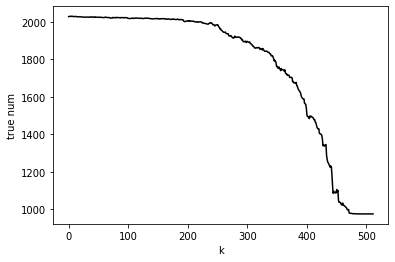

In [30]:
import pandas as pd
df_mal = pd.DataFrame(mal_pred)
df_mal.columns = ['mal']
#plt.plot(arr)
plt.plot([x for x in range(len(df_mal))],df_mal['mal'], "-k")
plt.xlabel('k')
plt.ylabel('true num') 
# plt.savefig('prune-mal-1.png')
plt.show()

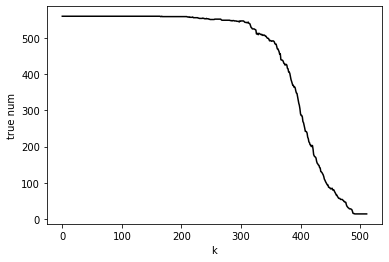

In [31]:
df_train_clean = pd.DataFrame(clean_train_pred)
df_train_clean.columns = ['train_clean']
#plt.plot(arr)
plt.plot([x for x in range(len(df_train_clean))],df_train_clean['train_clean'], "-k")
plt.xlabel('k')
plt.ylabel('true num')
# plt.savefig('prune-clean.png')
plt.show()

In [32]:
clean_test_pred = []
for neurons in range(neuron_num):
    new_params = copy.deepcopy(param_values)
    new_params['linear.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for batch in iterate_minibatches(X_test, y_test, 40):
            inputs, _ = batch
            network.eval()
            outputs = network(torch.from_numpy(inputs).to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_test))
    print(neurons, ':', ok)
    clean_test_pred.append(ok)

0 : 116
1 : 116
2 : 116
3 : 116
4 : 116
5 : 116
6 : 116
7 : 116
8 : 116
9 : 116
10 : 116
11 : 116
12 : 116
13 : 116
14 : 116
15 : 116
16 : 116
17 : 116
18 : 116
19 : 116
20 : 116
21 : 117
22 : 117
23 : 117
24 : 117
25 : 117
26 : 117
27 : 117
28 : 117
29 : 117
30 : 117
31 : 117
32 : 117
33 : 117
34 : 117
35 : 117
36 : 117
37 : 117
38 : 117
39 : 117
40 : 117
41 : 117
42 : 117
43 : 117
44 : 117
45 : 117
46 : 117
47 : 117
48 : 117
49 : 117
50 : 117
51 : 117
52 : 117
53 : 117
54 : 117
55 : 117
56 : 117
57 : 117
58 : 117
59 : 117
60 : 117
61 : 117
62 : 117
63 : 117
64 : 117
65 : 116
66 : 116
67 : 116
68 : 116
69 : 116
70 : 116
71 : 116
72 : 116
73 : 116
74 : 116
75 : 116
76 : 116
77 : 116
78 : 116
79 : 116
80 : 116
81 : 116
82 : 116
83 : 116
84 : 116
85 : 116
86 : 116
87 : 116
88 : 116
89 : 116
90 : 116
91 : 116
92 : 116
93 : 116
94 : 116
95 : 116
96 : 116
97 : 116
98 : 116
99 : 116
100 : 116
101 : 116
102 : 116
103 : 116
104 : 116
105 : 116
106 : 115
107 : 115
108 : 115
109 : 115
110 : 115


In [33]:
df_test = pd.DataFrame(clean_test_pred)

In [34]:
df = df_train_clean.copy()
df['mal'] = df_mal.copy()
df['test_clean'] = df_test.copy()

In [35]:
df['train_clean'] = df['train_clean']/len(X_train)
df['mal'] = df['mal']/len(X_mal)
df['test_clean'] = df['test_clean']/len(X_test)

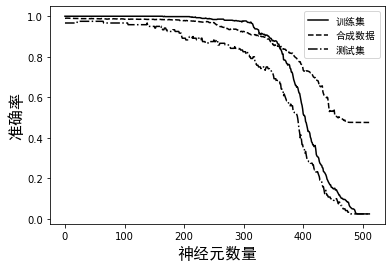

In [36]:
plt.plot([x for x in range(len(df['train_clean']))],df['train_clean'], "-k", label='训练集')
plt.plot([x for x in range(len(df['mal']))],df['mal'], "--k", label='合成数据')
plt.plot([x for x in range(len(df['test_clean']))],df['test_clean'], "-.k", label='测试集')
plt.xlabel('神经元数量',FontProperties=my_font,fontsize=16)
plt.ylabel('准确率',FontProperties=my_font,fontsize=16)
plt.legend(prop=my_font)
plt.savefig('prune-accuracy-olivetti-preact.png')

In [37]:
torch.save(new_params, 'prune-model-olivetti-preact.ckpt')